In [1]:
!pip install sentence_transformers


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from tensorflow.keras import layers, models, optimizers, losses, regularizers
import matplotlib.pyplot as plt

D:\PWR\semester_6\atificial intelligence\labs\lab5\lab5\.venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
sentence_transformer_model = SentenceTransformer('all-mpnet-base-v2')

D:\PWR\semester_6\atificial intelligence\labs\lab5\lab5\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
df_items = pd.read_csv('./data/jester_items.csv')
df_ratings = pd.read_csv('./data/jester_ratings.csv')

In [5]:
df_items['joke_embedded'] = df_items['jokeText'].apply(lambda x: sentence_transformer_model.encode(x))

In [6]:
combined_df = pd.merge(df_items,df_ratings,how='inner',on=['jokeId'])

In [7]:
combined_df.head()

,jokeId,jokeText,joke_embedded,userId,rating
0,5,Q.\tWhat's O. J. Simpson's Internet address? \...,"[0.051882718, 0.09469988, 0.0058203074, 0.0135...",1,0.219
1,5,Q.\tWhat's O. J. Simpson's Internet address? \...,"[0.051882718, 0.09469988, 0.0058203074, 0.0135...",2,-9.688
2,5,Q.\tWhat's O. J. Simpson's Internet address? \...,"[0.051882718, 0.09469988, 0.0058203074, 0.0135...",3,-9.844
3,5,Q.\tWhat's O. J. Simpson's Internet address? \...,"[0.051882718, 0.09469988, 0.0058203074, 0.0135...",4,-5.812
4,5,Q.\tWhat's O. J. Simpson's Internet address? \...,"[0.051882718, 0.09469988, 0.0058203074, 0.0135...",5,6.906


In [8]:
num_users = combined_df.userId.nunique()
num_users

59132

In [9]:
# Step 2: Identify unique user IDs
unique_ids = combined_df['userId'].unique()

# Step 3: Create a mapping of old IDs to new contiguous IDs
id_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_ids, start=0)}

# Step 4: Replace old user IDs with new contiguous IDs in the DataFrame
combined_df['userId'] = combined_df['userId'].map(id_mapping)

In [10]:

# Define function to create model with variable size and regularization
def create_model(learning_rate, num_neurons, num_users, joke_embedding_size, regularization_factor=0.01):
    # Define user input and embedding
    user_embedding_dim = 8
    user_input = layers.Input(shape=(1,), name='user_input')
    user_embedding = layers.Embedding(input_dim=num_users, output_dim=user_embedding_dim, input_length=1)(user_input)
    user_embedding = layers.Flatten()(user_embedding)

    # Define joke input
    joke_input = layers.Input(shape=(joke_embedding_size,), name='joke_input')

    # Concatenate joke and user embeddings
    concatenated = layers.Concatenate()([joke_input, user_embedding])

    # Fully connected layers with variable number of neurons and L2 regularization
    x = layers.Dense(num_neurons[0], activation='relu', kernel_regularizer=regularizers.l2(regularization_factor))(concatenated)
    for neurons in num_neurons[1:]:
        x = layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor))(x)
    output = layers.Dense(1)(x)

    # Create and compile model
    model = models.Model(inputs=[joke_input, user_input], outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss=losses.MeanSquaredError())

    return model


In [11]:
X = combined_df[['userId','joke_embedded']]
Y = combined_df['rating']

In [12]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [13]:
import numpy as np

# Extract joke embeddings and user IDs for training and testing
train_joke_embeddings = np.vstack(X_train['joke_embedded'].values)
train_user_ids = X_train['userId'].values

test_joke_embeddings = np.vstack(X_test['joke_embedded'].values)
test_user_ids = X_test['userId'].values

In [14]:
epochs = 10
learning_rates = [0.001, 0.01, 0.1]
histories = {}
joke_embedding_size = combined_df.joke_embedded[1].size
regularization_factor = 0.01

In [15]:
test_size = [128,64]
model_sizes = {
    'small': [32, 16],
    'medium': [64, 32, 16],
    'large': [128, 64, 32, 16]
}

In [69]:
# Train the model with different learning rates
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = create_model(lr,test_size,num_users, joke_embedding_size,regularization_factor)
    history = model.fit(
        [train_joke_embeddings, train_user_ids], y_train,
        validation_data=([test_joke_embeddings, test_user_ids], y_test),
        epochs=epochs,
        batch_size=32,
        verbose=1
    )
    histories[lr] = history

Training with learning rate: 0.001


D:\PWR\semester_6\atificial intelligence\labs\lab5\lab5\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 168s 4ms/step - loss: 21.6682 - val_loss: 18.9232
Epoch 2/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 177s 4ms/step - loss: 18.0462 - val_loss: 18.4577
Epoch 3/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 268s 6ms/step - loss: 17.5459 - val_loss: 18.2967
Epoch 4/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 177s 4ms/step - loss: 17.0169 - val_loss: 18.1170
Epoch 5/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 158s 4ms/step - loss: 16.5681 - val_loss: 18.2317
Epoch 6/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 144s 3ms/step - loss: 16.3631 - val_loss: 17.9402
Epoch 7/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 138s 3ms/step - loss: 16.1907 - val_loss: 17.8736
Epoch 8/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 136s 3ms/step - loss: 16.0237 - val_loss: 17.8755
Epoch 9/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 135s 3ms/step - loss: 15.9211 - val_loss: 17.9834
Epoch 10/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 154s 3ms/step - loss: 15.8927 - val_loss: 17.9029
Training with learning rate: 0.01


D:\PWR\semester_6\atificial intelligence\labs\lab5\lab5\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 152s 3ms/step - loss: 22.0236 - val_loss: 19.5487
Epoch 2/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 145s 3ms/step - loss: 18.8010 - val_loss: 19.4769
Epoch 3/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 172s 4ms/step - loss: 18.4401 - val_loss: 19.7729
Epoch 4/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 179s 4ms/step - loss: 18.3237 - val_loss: 19.3946
Epoch 5/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 151s 3ms/step - loss: 18.2234 - val_loss: 19.1681
Epoch 6/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 148s 3ms/step - loss: 18.2106 - val_loss: 19.1728
Epoch 7/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 147s 3ms/step - loss: 18.2363 - val_loss: 20.8210
Epoch 8/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 154s 3ms/step - loss: 18.1772 - val_loss: 19.0840
Epoch 9/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 173s 4ms/step - loss: 18.1888 - val_loss: 19.4891
Epoch 10/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 160s 4ms/step - loss: 18.2285 - val_loss: 19.3965
Training with learning rate: 0.1


D:\PWR\semester_6\atificial intelligence\labs\lab5\lab5\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 184s 4ms/step - loss: 26.7981 - val_loss: 28.0452
Epoch 2/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 159s 4ms/step - loss: 28.1588 - val_loss: 28.0894
Epoch 3/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 157s 4ms/step - loss: 28.2149 - val_loss: 28.1095
Epoch 4/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 148s 3ms/step - loss: 28.1628 - val_loss: 28.0588
Epoch 5/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 148s 3ms/step - loss: 28.1943 - val_loss: 28.1425
Epoch 6/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 146s 3ms/step - loss: 28.1813 - val_loss: 28.0945
Epoch 7/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 147s 3ms/step - loss: 28.2051 - val_loss: 28.0658
Epoch 8/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 158s 4ms/step - loss: 28.1657 - val_loss: 28.0470
Epoch 9/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 152s 3ms/step - loss: 28.1868 - val_loss: 28.0438
Epoch 10/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 151s 3ms/step - loss: 28.2187 - val_loss: 28.0523


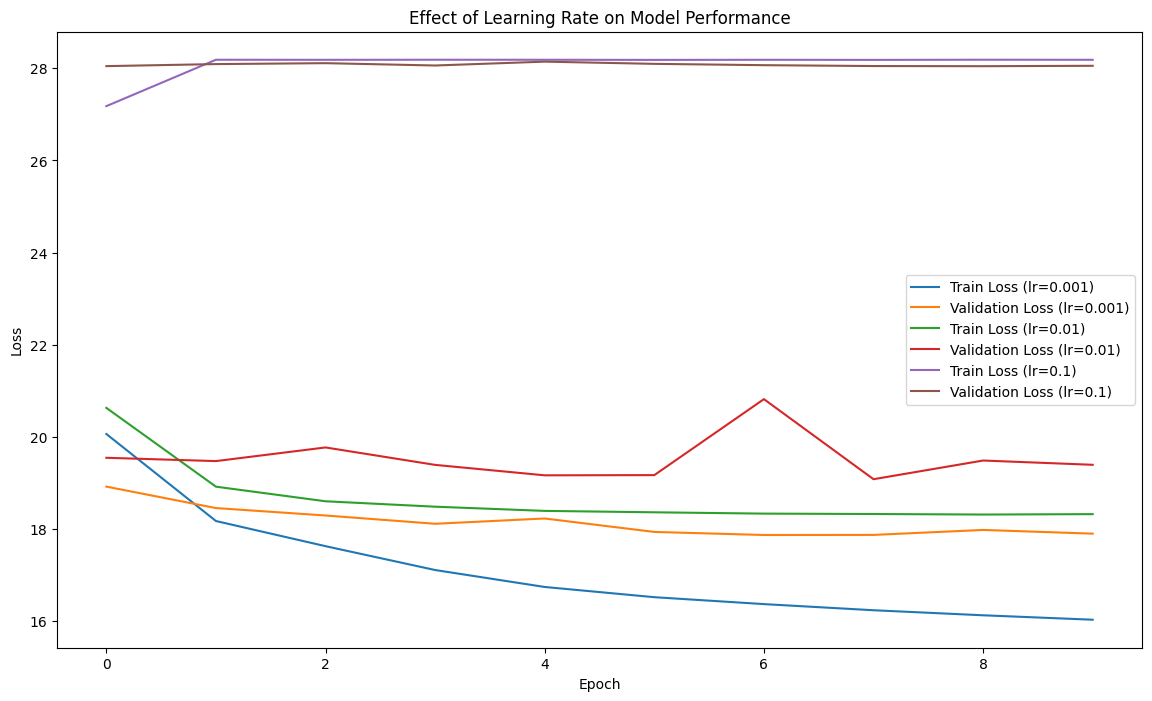

In [70]:
plt.figure(figsize=(14, 8))

for lr, history in histories.items():
    plt.plot(history.history['loss'], label=f'Train Loss (lr={lr})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (lr={lr})')

plt.title('Effect of Learning Rate on Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model sizes 

In [18]:
size_histories = {}

In [ ]:
learning_rate = 0.001
# Train the model with different sizes
for size, neurons in model_sizes.items():
    print(f"Training with {size} model")
    model = create_model( learning_rate,neurons, num_users, joke_embedding_size )
    history = model.fit(
        [train_joke_embeddings, train_user_ids], y_train,
        validation_data=([test_joke_embeddings, test_user_ids], y_test),
        epochs=epochs,
        batch_size=32,
        verbose=1
    )
    size_histories[size] = history

Training with small model


D:\PWR\semester_6\atificial intelligence\labs\lab5\lab5\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 175s 4ms/step - loss: 21.6867 - val_loss: 18.7313
Epoch 2/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 178s 4ms/step - loss: 18.0763 - val_loss: 18.4827
Epoch 3/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 162s 4ms/step - loss: 17.6166 - val_loss: 18.1023
Epoch 4/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 160s 4ms/step - loss: 17.0145 - val_loss: 18.0655
Epoch 5/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 161s 4ms/step - loss: 16.5505 - val_loss: 18.0155
Epoch 6/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 159s 4ms/step - loss: 16.3358 - val_loss: 17.8957
Epoch 7/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 160s 4ms/step - loss: 16.1959 - val_loss: 18.0504
Epoch 8/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 159s 4ms/step - loss: 16.0852 - val_loss: 17.8417
Epoch 9/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 160s 4ms/step - loss: 16.0028 - val_loss: 17.8646
Epoch 10/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 158s 4ms/step - loss: 15.9340 - val_loss: 17.8167
Training with medium model


D:\PWR\semester_6\atificial intelligence\labs\lab5\lab5\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 188s 4ms/step - loss: 21.7403 - val_loss: 18.7972
Epoch 2/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 171s 4ms/step - loss: 18.1379 - val_loss: 18.4603
Epoch 3/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 174s 4ms/step - loss: 17.7157 - val_loss: 18.3729
Epoch 4/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 172s 4ms/step - loss: 17.5711 - val_loss: 18.2950
Epoch 5/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 173s 4ms/step - loss: 17.4302 - val_loss: 18.2747
Epoch 6/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 214s 5ms/step - loss: 17.2846 - val_loss: 18.2804
Epoch 7/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 220s 5ms/step - loss: 16.9839 - val_loss: 18.0396
Epoch 8/10
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 204s 5ms/step - loss: 16.7117 - val_loss: 18.0761
Epoch 9/10
24201/44036 ━━━━━━━━━━━━━━━━━━━━ 15:14 46ms/step - loss: 16.5101

In [19]:
learning_rate = 0.01
# Train the model with different sizes
for size, neurons in model_sizes.items():
    print(f"Training with {size} model")
    model = create_model( learning_rate,neurons, num_users, joke_embedding_size )
    history = model.fit(
        [train_joke_embeddings, train_user_ids], y_train,
        validation_data=([test_joke_embeddings, test_user_ids], y_test),
        epochs=3,
        batch_size=32,
        verbose=1
    )
    size_histories[size] = history

Training with small model


D:\PWR\semester_6\atificial intelligence\labs\lab5\lab5\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 223s 5ms/step - loss: 21.8806 - val_loss: 19.3468
Epoch 2/3
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 194s 4ms/step - loss: 18.7110 - val_loss: 19.3933
Epoch 3/3
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 177s 4ms/step - loss: 18.3047 - val_loss: 19.1504
Training with medium model


D:\PWR\semester_6\atificial intelligence\labs\lab5\lab5\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 211s 5ms/step - loss: 22.0643 - val_loss: 19.3965
Epoch 2/3
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 235s 5ms/step - loss: 18.8602 - val_loss: 19.4721
Epoch 3/3
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/step - loss: 18.4841 - val_loss: 19.3340
Training with large model


D:\PWR\semester_6\atificial intelligence\labs\lab5\lab5\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 238s 5ms/step - loss: 22.1695 - val_loss: 19.4606
Epoch 2/3
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 249s 6ms/step - loss: 18.9450 - val_loss: 19.1701
Epoch 3/3
44036/44036 ━━━━━━━━━━━━━━━━━━━━ 251s 6ms/step - loss: 18.5465 - val_loss: 20.2057


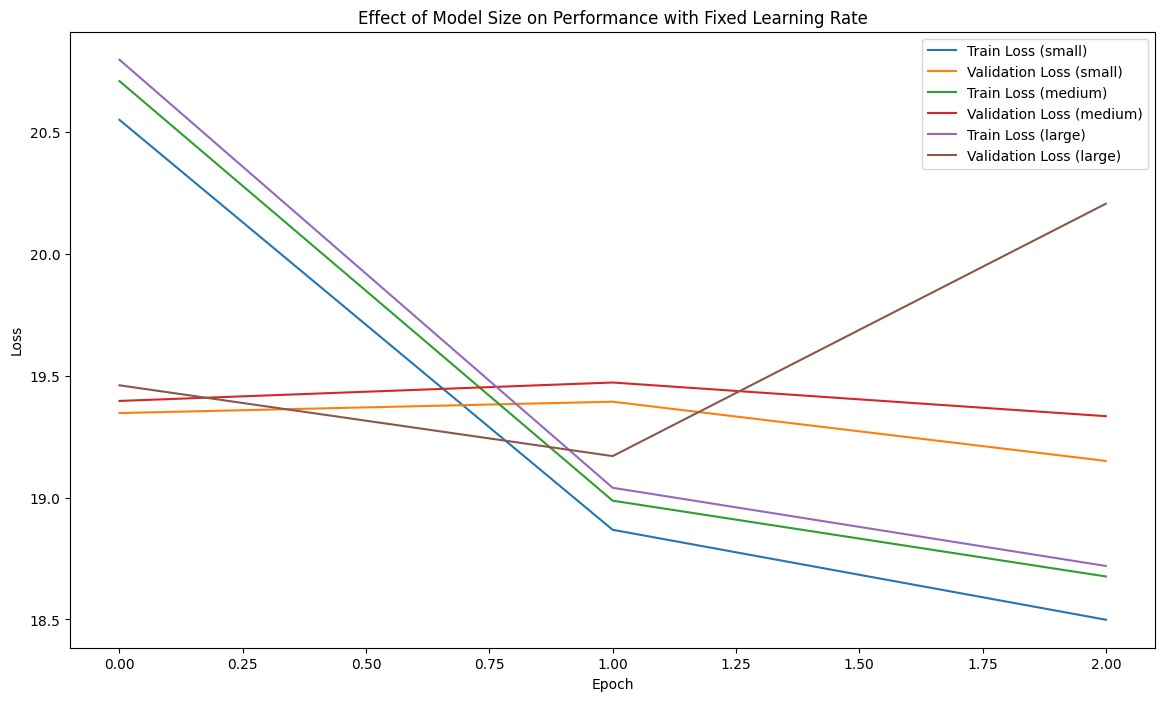

In [20]:
# Plotting the results
plt.figure(figsize=(14, 8))

for size, history in size_histories.items():
    plt.plot(history.history['loss'], label=f'Train Loss ({size})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss ({size})')

plt.title('Effect of Model Size on Performance with Fixed Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
import numpy as np

def predict_rating(userId, joke):
    # Encode the joke using the sentence transformer model
    embedded_value = sentence_transformer_model.encode(joke)
    
    # Print the shape and type of the embedded value
    print(f'Embedded value shape: {embedded_value.shape}, type: {type(embedded_value)}')
    
    # Ensure userId is in the correct format (e.g., an array or tensor)
    if isinstance(userId, int):
        userId = np.array([userId])
    
    # Print the shape and type of userId
    print(f'userId shape: {userId.shape}, type: {type(userId)}')
    
    # Ensure userId is shaped correctly for the model (batch size of 1, 1 input)
    userId = np.reshape(userId, (1, 1))
    
    # Ensure embedded_value is shaped correctly for the model (batch size of 1)
    embedded_value = np.reshape(embedded_value, (1, -1))
    
    # Print the final shapes and types of the inputs
    print(f'Final embedded value shape: {embedded_value.shape}, type: {type(embedded_value)}')
    print(f'Final userId shape: {userId.shape}, type: {type(userId)}')
    
    # Predict the rating using the model
    prediction = model.predict([embedded_value, userId])
    
    return prediction


In [41]:
userId = 1  # Example user ID
joke = "Why don't scientists trust atoms? Because they make up everything!"
print(predict_rating(userId, joke))


Embedded value shape: (768,), type: <class 'numpy.ndarray'>
userId shape: (1,), type: <class 'numpy.ndarray'>
Final embedded value shape: (1, 768), type: <class 'numpy.ndarray'>
Final userId shape: (1, 1), type: <class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
[[2.258782]]
